In [72]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [73]:
data = pd.read_csv('MXvideos_cc50_202101.csv')

In [74]:
data_limpia = data.drop_duplicates()
data_limpia = data_limpia.drop_duplicates(subset='video_id')

In [75]:
#Verificar datos faltantes
def imprimir_nulos(df):
    total = len(df)
    for col in df.columns:
        nulos = df[col].isnull().sum()
        if nulos > 0:
            porcentaje = round((nulos / total) * 100, 2)
            print(f"La columna '{col}' tiene {nulos} datos vacíos, representan un {porcentaje}% de los registros")

print("Reporte de valores nulos tras eliminar duplicados:\n")
imprimir_nulos(data_limpia)

Reporte de valores nulos tras eliminar duplicados:

La columna 'video_id' tiene 1 datos vacíos, representan un 0.0% de los registros
La columna 'trending_date' tiene 665 datos vacíos, representan un 1.94% de los registros
La columna 'title' tiene 701 datos vacíos, representan un 2.05% de los registros
La columna 'channel_title' tiene 710 datos vacíos, representan un 2.07% de los registros
La columna 'category_id' tiene 738 datos vacíos, representan un 2.15% de los registros
La columna 'publish_time' tiene 738 datos vacíos, representan un 2.15% de los registros
La columna 'tags' tiene 725 datos vacíos, representan un 2.12% de los registros
La columna 'views' tiene 738 datos vacíos, representan un 2.15% de los registros
La columna 'likes' tiene 738 datos vacíos, representan un 2.15% de los registros
La columna 'dislikes' tiene 738 datos vacíos, representan un 2.15% de los registros
La columna 'comment_count' tiene 738 datos vacíos, representan un 2.15% de los registros
La columna 'thumbn

In [76]:
#Eliminar datos críticos que representan una minoría del dataset
total = len(data_limpia)
columnas_criticas = [
    'video_id', 'trending_date', 'title', 'channel_title', 'category_id',
    'publish_time', 'tags', 'views', 'likes', 'dislikes'
]

for col in columnas_criticas:
    nulos = data_limpia[col].isnull().sum()
    porcentaje = nulos / total
    if porcentaje <= 0.10 and nulos > 0:
        print(f"Eliminando {nulos} registros con nulos en columna crítica: {col} ({round(porcentaje*100,2)}%)")
        data_limpia = data_limpia[data_limpia[col].notnull()]

print("\nValores nulos restantes después de limpieza final:")
imprimir_nulos(data_limpia)

Eliminando 1 registros con nulos en columna crítica: video_id (0.0%)
Eliminando 664 registros con nulos en columna crítica: trending_date (1.94%)
Eliminando 36 registros con nulos en columna crítica: title (0.11%)
Eliminando 9 registros con nulos en columna crítica: channel_title (0.03%)
Eliminando 28 registros con nulos en columna crítica: category_id (0.08%)

Valores nulos restantes después de limpieza final:
La columna 'description' tiene 3627 datos vacíos, representan un 10.82% de los registros


In [77]:
#Imputar una descripción simbólica a aquellos registros sin descripción
def rellenar_descripcion(df):
    if 'description' in df.columns:
        df['description'] = df['description'].fillna("Sin descripción")
    return df

data_limpia = rellenar_descripcion(data_limpia)
imprimir_nulos(data_limpia)

In [78]:
columnas = ['views', 'likes', 'dislikes', 'comment_count']

for col in columnas:
    Q1 = data_limpia[col].quantile(0.25)
    Q3 = data_limpia[col].quantile(0.75)
    minimo = data_limpia[col].min()
    maximo = data_limpia[col].max()
    print(f"{col} → Min: {minimo:.2f}, Q1: {Q1:.2f}, Q3: {Q3:.2f}, Max: {maximo:.2f}")

views → Min: 157.00, Q1: 13805.00, Q3: 137410.00, Max: 39349928.00
likes → Min: 0.00, Q1: 248.00, Q3: 4984.00, Max: 3880211.00
dislikes → Min: 0.00, Q1: 14.00, Q3: 171.00, Max: 483969.00
comment_count → Min: 0.00, Q1: 33.00, Q3: 632.00, Max: 692356.00


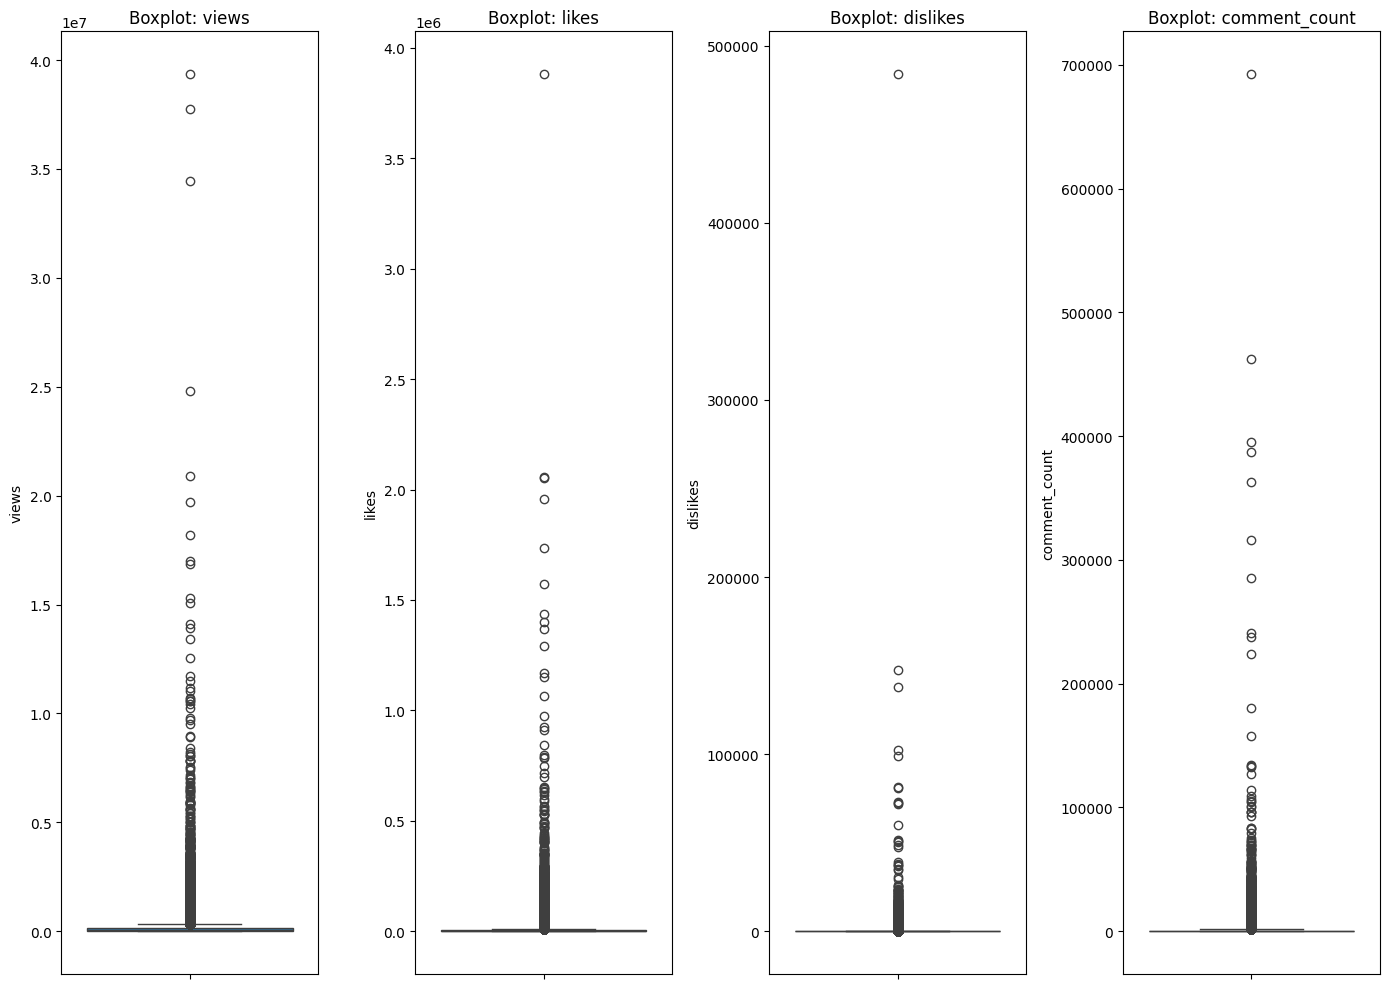

In [79]:
# Boxplots para identificar outliers en columnas numéricas
plt.figure(figsize=(14, 10))
for i, col in enumerate(['views', 'likes', 'dislikes', 'comment_count']):
    plt.subplot(1, 4, i + 1)
    sns.boxplot(y=data_limpia[col])
    plt.title(f'Boxplot: {col}')
plt.tight_layout()
plt.show()

#📌 Winsorización
Se aplicó la winsorización al 1% y 99% para reducir la influencia de valores extremos sin eliminar registros. Esta técnica conserva la integridad del dataset y estabiliza medidas como la media y la varianza, especialmente en variables con datos altamente virales como views y likes.

#📌 Transformación logarítmica
Se utilizó la transformación logarítmica (log(x + 1)) para comprimir la escala de las variables numéricas y mejorar su interpretabilidad. Esto facilita comparaciones proporcionales, análisis de tendencias y modelos predictivos, al suavizar distribuciones sesgadas.

| Nº | Pregunta                                                                             | ¿Usar log? | Justificación                                                                      |
| -- | ------------------------------------------------------------------------------------ | ---------- | ---------------------------------------------------------------------------------- |
| 1  | ¿Qué categorías de videos son las de mayor tendencia?                                | ❌          | Puedes usar conteo de videos o views directos (sin log).                           |
| 2  | ¿Qué categorías de videos son los que más gustan? ¿Y las que menos gustan?           | ✅          | El log evita que unos pocos videos con millones de likes dominen el promedio.      |
| 3  | ¿Qué categorías tienen mejor ratio “Me gusta” / “No me gusta”?                       | ✅          | El uso de `log(likes+1)/log(dislikes+1)` estabiliza proporciones sesgadas.         |
| 4  | ¿Qué categorías tienen mejor ratio “Vistas” / “Comentarios”?                         | ✅          | El log ayuda a interpretar mejor la interacción media, evitando valores extremos.  |
| 5  | ¿Cómo ha cambiado el volumen de videos en tendencia a lo largo del tiempo?           | ❌          | Puedes usar conteo directo por fecha o categoría.                                  |
| 6  | ¿Qué Canales son tendencia más frecuentemente? ¿Y cuáles con menos frecuencia?       | ❌          | Aquí se usa frecuencia (conteo), no valores numéricos extremos.                    |
| 7  | ¿En qué Estados se presenta el mayor número de “Vistas”, “Me gusta” y “No me gusta”? | ✅          | Sumar con log reduce distorsión por 1 solo video viral por estado.                 |
| 8  | ¿Los videos en tendencia son los que más comentarios positivos reciben?              | ✅          | El log ayuda a analizar correlaciones más suaves con `comment_count`.              |
| 9  | ¿Es factible predecir el número de “Vistas”, “Me gusta” o “No me gusta”?             | ✅          | La regresión funciona mejor con variables transformadas para estabilizar varianza. |


In [80]:
# 1. Aplicar winsorización al 1% y 99%
def winsorizar(df, columnas, limite_inferior=0.01, limite_superior=0.99):
    for col in columnas:
        p_inf = df[col].quantile(limite_inferior)
        p_sup = df[col].quantile(limite_superior)
        df[col] = df[col].clip(lower=p_inf, upper=p_sup)
        print(f"--> Winsorización aplicada a '{col}' entre P1={p_inf:.2f} y P99={p_sup:.2f}")
    return df

columnas_numericas = ['views', 'likes', 'dislikes', 'comment_count']
data_limpia = winsorizar(data_limpia, columnas_numericas)

# 2. Aplicar transformación logarítmica (log1p = log(x+1))
for col in columnas_numericas:
    data_limpia[f'{col}_log'] = np.log1p(data_limpia[col])
    print(f"=> Transformación logarítmica aplicada a '{col}' → '{col}_log'")

data_limpia[[f'{col}_log' for col in columnas_numericas]].describe()

--> Winsorización aplicada a 'views' entre P1=2100.24 y P99=2322629.64
--> Winsorización aplicada a 'likes' entre P1=0.00 y P99=139016.72
--> Winsorización aplicada a 'dislikes' entre P1=0.00 y P99=4821.76
--> Winsorización aplicada a 'comment_count' entre P1=0.00 y P99=20643.64
=> Transformación logarítmica aplicada a 'views' → 'views_log'
=> Transformación logarítmica aplicada a 'likes' → 'likes_log'
=> Transformación logarítmica aplicada a 'dislikes' → 'dislikes_log'
=> Transformación logarítmica aplicada a 'comment_count' → 'comment_count_log'


,views_log,likes_log,dislikes_log,comment_count_log
count,33513.000000,33513.000000,33513.000000,33513.000000
mean,10.732152,6.952142,3.940854,4.973980
std,1.584120,2.223292,1.800233,2.131632
min,7.650283,0.000000,0.000000,0.000000
25%,9.532859,5.517453,2.708050,3.526361
50%,10.637537,6.880384,3.850148,5.023881
75%,11.830732,8.514189,5.147494,6.450470
max,14.658211,11.842357,8.481102,9.935211
